# Generative Discriminative Models for the MNIST Dataset

This notebook lays the foundation for the other notebook (MNIST_DCGAN). Here we will analyze the discriminator and generator models to be used later in the GAN explorations.

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
from scipy import interpolate
from scipy.special import softmax

import utilities as utils
import models 

<br><br><br>

# Data

## Load Dataset

In [2]:
train_set, test_set = tf.keras.datasets.mnist.load_data()
print(f"\tTrain set: {train_set[0].shape}, {train_set[1].shape}")
print(f"\tTest set:  {test_set[0].shape}, {test_set[1].shape}")

	Train set: (60000, 28, 28), (60000,)
	Test set:  (10000, 28, 28), (10000,)


## Random Image with Similar Statistics

In [ ]:
x = train_set[0]
heights, bins = np.histogram(x.flatten(), bins=200, density=True) 

cumulative_sum = np.cumsum(heights)
cumulative_sum = np.append(0.0, cumulative_sum)
cumulative_sum /= np.amax(cumulative_sum)

f = interpolate.interp1d(cumulative_sum, bins)

fig = plt.figure(figsize=(18., 4.))
#
ax = plt.subplot(1, 2, 1)
ax.set_title("Histogram")
ax.bar(
    0.5*(bins[1:] + bins[:-1]), 
    heights, width=(bins[1] - bins[0]), 
    align="center", color="steelblue", edgecolor="black")
ax.grid()
ax.set_axisbelow(True)
#
ax = plt.subplot(1, 2, 2)
ax.set_title("Cumulative Histogram")
ax.plot(bins, cumulative_sum, lw=2.0, color="steelblue", label="original")
y = np.linspace(start=0.0, stop=1.0, num=20, endpoint=True)
ax.plot(f(y), y, ls="", marker="o", markersize=5.0, color="salmon", label="interpolated")
ax.legend()
ax.set_ylim(0.0, 1.05)
ax.grid()
ax.set_axisbelow(True)
#
plt.show()

In [ ]:
x_shape = train_set[0].shape
x_size = np.prod(x_shape)
fake_x_train = f(np.random.random(x_size)).reshape(x_shape)

In [ ]:
fig = plt.figure(figsize=(18., 8.))
#
ax = plt.subplot(2, 1, 1)
_, bins, _ = ax.hist(train_set[0].flatten(), bins=256, density=True, align="mid", 
    rwidth=0.8, color="steelblue", edgecolor="black", alpha=0.5, label="Real")
ax.grid()
ax.set_xlim(-1.0, 257.0)
ax.set_yscale("log")
ax.set_axisbelow(True)
#
ax = plt.subplot(2, 1, 2, sharex=ax, sharey=ax)
_, bins, _ = ax.hist(fake_x_train.flatten(), bins=bins, density=True, align="mid", 
    rwidth=0.8, color="salmon", edgecolor="black", alpha=0.5, label="fake")
ax.grid()
ax.set_axisbelow(True)
#
plt.show()

## Generator Classes

In [ ]:
generator = utils.MNIST_or_Noise_Sequence_Generator(
    train_set[0][..., np.newaxis], fake_x_train[..., np.newaxis], 64)

num_rows = 10
num_cols = 10

fig = plt.figure(figsize=(18., 18.))
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.025, hspace=0.05)
for row in range(num_rows):
    for col in range(num_cols):
        idx = row * num_cols + col
        ax = plt.subplot(gs[idx])
        images, labels = generator[idx]
        ax.imshow(images[-1,...], cmap="gray")
        if labels[-1]:
            circ = plt.Circle((2.0, 2.0), 1.5, color="green", alpha=1.0)
            ax.add_patch(circ)
        else:
            circ = plt.Circle((2.0, 2.0), 1.5, color="red", alpha=1.0)
            ax.add_patch(circ)
        ax.axis("off")
plt.show()

To prevent the discriminator network from learning the obvious aggregation in the real images in the initial traiing phase, we scramble the real images:

In [ ]:
scrambler = utils.Scrambler(train_set[0].shape[-2:])
real_images = scrambler.scramble(train_set[0])
generator = utils.MNIST_or_Noise_Sequence_Generator(
    real_images[..., np.newaxis], fake_x_train[..., np.newaxis], 64)

In [ ]:
unscramble_image = False

num_rows = 10
num_cols = 10

fig = plt.figure(figsize=(18., 18.))
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.025, hspace=0.05)
for row in range(num_rows):
    for col in range(num_cols):
        idx = row * num_cols + col
        ax = plt.subplot(gs[idx])
        images, labels = generator[idx]
        if labels[-1]:
            if unscramble_image:
                ax.imshow(scrambler.unscramble(images[-1,...]), cmap="gray")
            else:
                ax.imshow(images[-1,...], cmap="gray")
            circ = plt.Circle((2.0, 2.0), 1.5, color="green", alpha=1.0)
            ax.add_patch(circ)
        else:
            ax.imshow(images[-1,...], cmap="gray")
            circ = plt.Circle((2.0, 2.0), 1.5, color="red", alpha=1.0)
            ax.add_patch(circ)
        ax.axis("off")
plt.show()

<br><br><br>

# Discriminator Model

### Instantiate Model

In [ ]:
discriminator_model = models.construct_discriminator_model()

discriminator_model.summary(print_fn=(lambda *args: print("\t", *args)))

### Compile Model

In [ ]:
use_sgd_optimizer = True

if use_sgd_optimizer:
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=0.001, momentum=0.0, nesterov=False, name='SGD')
else:
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001, beta_1=0.9, beta_2=0.999, 
        epsilon=1e-07, amsgrad=False, name='Adam')

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, name="crossentropy")

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]

discriminator_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

### Train

In [ ]:
num_epochs = 3

# Early stoppying callback:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss", 
    min_delta=0.0005, 
    patience=20, 
    verbose=1,
    mode="min", 
    baseline=None, 
    restore_best_weights=True)

scrambler = utils.Scrambler(train_set[0].shape[-2:])
real_images = scrambler.scramble(train_set[0])
generator = utils.MNIST_or_Noise_Sequence_Generator(
    real_images[..., np.newaxis], fake_x_train[..., np.newaxis], 64)

# Fit model
fit_history = discriminator_model.fit(
    generator,
    epochs=num_epochs,
    verbose=1,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    workers=8,
    callbacks=[
        early_stopping_callback
    ])

### Evaluate

In [ ]:
x_shape = test_set[0].shape
x_size = np.prod(x_shape)
fake_x_test = f(np.random.random(x_size)).reshape(x_shape)

real_images = scrambler.scramble(test_set[0])
generator = utils.MNIST_or_Noise_Sequence_Generator(
    real_images[..., np.newaxis], fake_x_test[..., np.newaxis], 64)

eval_results = discriminator_model.evaluate(
    generator, return_dict=True)
for name, val in eval_results.items():
    print(f"{name}: {round(float(val), 5)}")

Okay, so far we have a discriminator that seems to be doing a good job.

<br><br><br>

# Generator Model 

In [3]:
generator_model = models.construct_generator_model(
    input_size=10, 
    output_activation="linear",
    with_batchnorm=True)

generator_model.summary(print_fn=(lambda *args: print("\t", *args)))

	 Model: "generator"
	 _________________________________________________________________
	 Layer (type)                 Output Shape              Param #   
	 input_1 (InputLayer)         [(None, 10)]              0         
	 _________________________________________________________________
	 dense_1 (Dense)              (None, 256)               2816      
	 _________________________________________________________________
	 leaky_relu_1 (LeakyReLU)     (None, 256)               0         
	 _________________________________________________________________
	 dense_2 (Dense)              (None, 4096)              1052672   
	 _________________________________________________________________
	 leaky_relu_2 (LeakyReLU)     (None, 4096)              0         
	 _________________________________________________________________
	 reshape (Reshape)            (None, 4, 4, 256)         0         
	 _________________________________________________________________
	 deconv_1 (Conv2DTranspose

## Testing the Generator Model

In [4]:
use_sgd_optimizer = False

if use_sgd_optimizer:
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=0.001, momentum=0.0, nesterov=False, name='SGD')
else:
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001, beta_1=0.9, beta_2=0.999, 
        epsilon=1e-07, amsgrad=False, name='Adam')

loss = tf.keras.losses.MeanSquaredError(name="mse")

generator_model.compile(loss=loss, optimizer=optimizer, metrics=[])

In [5]:
num_epochs = 4

# Early stoppying callback:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss", 
    min_delta=0.0005, 
    patience=20, 
    verbose=1,
    mode="min", 
    baseline=None, 
    restore_best_weights=True)

# Fit model
fit_history = generator_model.fit(
    x=tf.keras.utils.to_categorical(train_set[1], 10),
    y=train_set[0][..., np.newaxis],
    batch_size=16,
    epochs=num_epochs,
    verbose=1,
    validation_split=0.0,
    shuffle=True,
    class_weight=None,
    workers=8,
    callbacks=[
        early_stopping_callback
    ])

Epoch 1/4
3750/3750 [==============================] - 231s 61ms/step - loss: 7122.1665
Epoch 2/4
3750/3750 [==============================] - 238s 63ms/step - loss: 3491.4448
Epoch 3/4
3750/3750 [==============================] - 227s 61ms/step - loss: 3487.8572
Epoch 4/4
3750/3750 [==============================] - 223s 60ms/step - loss: 3484.5938


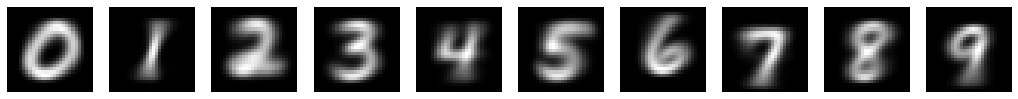

In [6]:
generated_images = generator_model.predict(tf.keras.utils.to_categorical(list(range(10)), 10))

n = 1
fig = plt.figure(figsize=(18., 2.))
for image in generated_images:
    ax = plt.subplot(1, 10, n)
    ax.imshow(np.clip(image, 0.0, 255.0).astype(np.uint8), cmap="gray")
    ax.axis("off")
    n += 1
plt.show()

### Combining the hidden representations:

Let's see what we get if we pass on defused distributions. The parameter `temperature` controls the sharpness of the input.

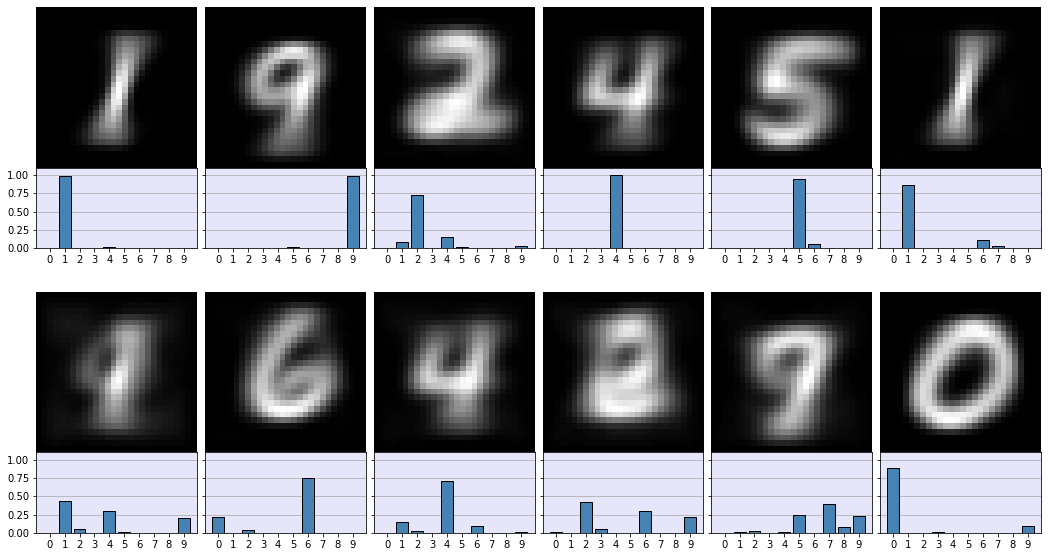

In [7]:
temperature = 5.0
hidden_reps = softmax(np.random.randn(32, 10) * temperature , axis=1)
generated_images = generator_model.predict(hidden_reps)
x = np.arange(10, dtype=np.float32)

num_rows = 2
num_cols = 6
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.05, hspace=0.1)
fig = plt.figure(figsize=(18., 10.))
for row in range(num_rows):
    for col in range(num_cols):
        idx = row * num_cols + col
        ax = plt.subplot(gs[idx])
        image = generated_images[idx, ...]
        image = np.clip(image, 0.0, 255.0).astype(np.uint8)
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        #
        divider = make_axes_locatable(ax)
        bar_ax = divider.append_axes("bottom", size="50%", pad=0.0)
        hidden_rep = hidden_reps[idx, ...]
        bar_ax.bar(x, hidden_rep, width=0.8, align="center", 
                   color="steelblue", edgecolor="black")
        bar_ax.set_facecolor("lavender")
        bar_ax.set_xticks(x)
        bar_ax.set_xticklabels(x.astype(np.int32))
        bar_ax.set_ylim(0.0, 1.1)
        bar_ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
        bar_ax.yaxis.grid()
        bar_ax.set_axisbelow(True)
        if col != 0:
            bar_ax.set_yticklabels([])
plt.show()